# <div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Extremely randomized trees</div>

<img src="./ressource/111.png" width=250/> <br>

Les arbres de décision et en particulier la méthode RandomForest constituent des méthodes sur étagère parmi les plus efficace à notre disposition. Nous nous intéressons aujourd’hui à une évolution de l'apprentissage des arbres de décision constituant ces forêts. Aussi, dans ce notebook, nous ne nous arrêterons pas à une compréhension fine d'une méthode de Machine Learning. Parceque le monde réel est toujours présent au-delà des murs de l'école, nous appliquerons notre connaissance nouvellement acquise sur un cas pratique et directement utile.

Nous commencerons donc par quelques rappels rapides sur la methode RandomForest afin de se remettre en mémoire les bases nécessaires pour comprendre la méthode qui nous intéresse aujourd’hui : ExtremelyRandomizedTrees. Nous dévoilerons alors la puissance insoupçonnée de l'aléatoire avant de l'appliquer sur un problème de classification musicale. Nous conclurons enfin sur l'effet des différents hyper paramètres sur cette méthode. Je vous laisse bien entendu le plein usage et le plein droit à modification sur l'intégralité du contenu de ce notebook. 

1. [Rappels de la methodes random forest](#sec1)
2. [Extremely randomized trees : la force de l'aleas](#sec2)
3. [Mise en pratique, classification musicale](#sec3)
4. [Avantages, Résultats et hyper parametres](#sec4)

A l'issue de chaque partie vous trouverez un petit résumé des points importants à retenir

<div class="alert alert-warning" style="margin-top: 1em">
**Package et library nécessaires**:
<ul>
<li>sklearn</li>
<li>matplotlib</li>
<li>numpy</li>
<li>networkx </li>
</ul>
Tout devrait déjà fonctionner avec votre version de jupyter
dans le cas contraire, vous pouvez m'envoyer un mail
</div>


In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import tree
from os import system
from IPython.display import Image

# <a id="sec1"></a> 1. Rappels de la methode Random Forests

S'il existe de nombreuses méthodes pour entrainer des arbres de décision, la méthode RandomForest est sans doute la plus communément utilisé et parmi l'une des plus performante. Dans cette méthode un arbre est entrainé sur par Bootstrap sur une sélection aléatoire des données d'apprentissage A chaque nœud d'un arbre, la coupe optimale est déterminée par un ensemble aléatoire de K attributs sélectionné parmi ceux disponibles dans les données d'apprentissage

L'aléatoire se situe donc à deux endroits : dans la sélection des attributs et dans le bootstraping

<div class="alert alert-success" style="margin-top: 1em">
**A retenir sur la méthode Random Forest:**:
<ul>
<li>Méthode d'ensemble sur plusieurs arbres</li>
<li>Sélection aléatoire des attributs</li>
<li>Sélection aléatoire des données d'entrée (bootstraping)</li>
</ul>
Méthode très efficace probablement l'une des méthodes sur étagère parmi les plus performante
</div>

In [2]:
def disp_iris_tree(filename, treename):
    dotfile = open(filename+'.dot', 'w')
    tree.export_graphviz(treename, 
                         out_file = dotfile, 
                         feature_names = iris.feature_names,
                         class_names=iris.target_names,  
                         filled=True,
                         rounded=True,  
                         special_characters=True)
    dotfile.close()
    system("dot -Tpng "+filename+".dot -o "+filename+".png")
    return Image(filename+'.png')

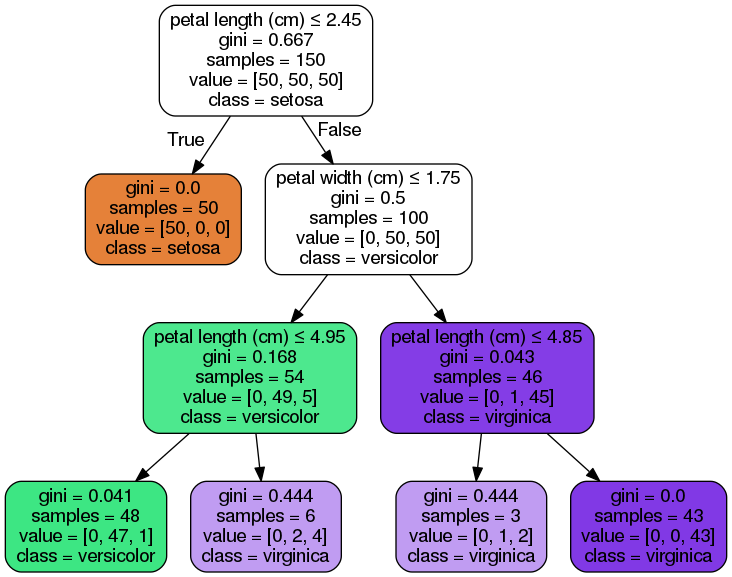

In [3]:
iris = datasets.load_iris()
iris_dt = tree.DecisionTreeClassifier(max_depth=3)
iris_dt.fit(iris.data, iris.target)
tree.export_graphviz(iris_dt,
                     out_file='tree.dot',
                     feature_names = iris.feature_names,
                     class_names=iris.target_names,
                     filled=True,
                     rounded=True,
                     special_characters=True)
disp_iris_tree('iris_dt',iris_dt)

Vous constaterez en relançant la celule que les valeurs des coupes changent peu et que la classification finale est plus ou moins toujours identique

# <a id="sec2"></a> 2. Extremely randomized trees : la force de l'aleas

La méthode ExtraTree exploite une approche légèrement différente des méthodes classique de type RandomForest. Les différences principales portent sur l’aléatoire et les points de la méthode qui dépendent d’un tirage aléatoire. 

Dans la méthode ExtraTree, l’aléatoire intervient à deux endroits. Les coupes, d’abord, sont choisies au hasard. En pratique et lorsque que l’on entraine un arbre, l’algorithme sélectionne aléatoirement un attribut et un seuil à partir duquel couper la population en deux. De manière plus précise, ce sont K coupes aléatoires qui sont proposées, chacune avec un seuil ac sur l’attribut k. De manière classique, celle retenu est celle qui maximise le score. Contrairement aux arbres de décision plus communs, il n’y a donc pas de recherche d’une coupe optimale. Ce choix diminue de beaucoup la complexité de l’algorithme et le rends plus rapide dans son exécution.

Une autre différence fondamentale est l'absence de bootstrap. Les arbres sont le plus souvent entrainés sur tout l'échantillon d'apprentissage. Le bootstrap est toujours possible mais en pratique n'améliore pas les résultats, les arbres étant déjà très aléatoires dans leur construction.

Afin de mieux saisir les tenants et aboutissant de la méthode, nous allons construire chacune des briques élémentaires qui la constitue. Je vous rassure, elle existe déjà dans scikitlearn et en pratique on fera appel au classifieur ExtraTreesClassifier plutôt que de la construire soit même.

Avant d'aborder les particularités de cette ExtraTree (l'abrégé de Extremely randomized tree), il est préférable de pouvoir évaluer les différentes coupes et sous échantillons qui seront générés. Ici, nous utiliserons l'indice d'impureté de Gini dont une implémentation est donnée ensuite suivant l'expression :

$$G = 1-\sum^{J}_{i=1} P_i$$ avec $J$ le nombre de classe et $P_i$ les proportions dans chaque classe

On cherchera donc à minimiser ce score pour avoir des classes les plus homogène possible

In [4]:
def gini_score(Y):
    """
    From
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """
    unique,counts = np.unique(Y, return_counts=True)
    return 1-np.sum([(e/np.sum(counts))**2 for e in counts])

Pour bien saisir comment fonctionne un ExtraTree, nous commencerons par sa différence fondamentale d'avec un arbre classique : la sélection de la coupe. Ici la coupe est donc sélectionnée aléatoirement (suivant une loi uniforme) dans l'intervalle des valeurs que prends une classe.

**Par exemple** : pour les fleurs, la taille du pétale évolue entre 0.1 et 2.5. La coupe sera donc prise aléatoirement au sein de cet intervalle.

In [5]:
import random
import numpy as np
def pick_a_random_split(X,Y,a):
    #Extraction de l'interval de valeurs au sein duquel se trouve le seuil a choisir
    a_min=min(X[:,a])
    a_max=max(X[:,a])
    #Selection d'un seuil alearoire (loi uniforme) dans cet interval 
    cut_point=np.random.uniform(a_min,a_max,1)
    #Calcul du score associé a ce seuil
    score=gini_score(Y[X[:,a]<cut_point])
    return cut_point,score

Construire un arbre n'est, en suite, pas très diffèrent de d'un arbre plus classique. De manière récursive, il s'agit de descendre de plus en plus profond (jusqu'à $n_{min}$) en sélectionnant à chaque nœuds $K$ attributs aléatoires sur lesquels couper à un seuil aléatoire $a_c$

Je vous ai implémenté une version personnelle du code décrit dans l'article [1] (Table 6)

<div class="alert alert-warning" style="margin-top: 1em">
NB: L'affichage est un peu plus artisanal que celui de ScikitLearn, ne vous inquiétez pas de ce qu'il y a dans G.add_node et G.add_edge c'est juste pour l'affichage. 
</div>

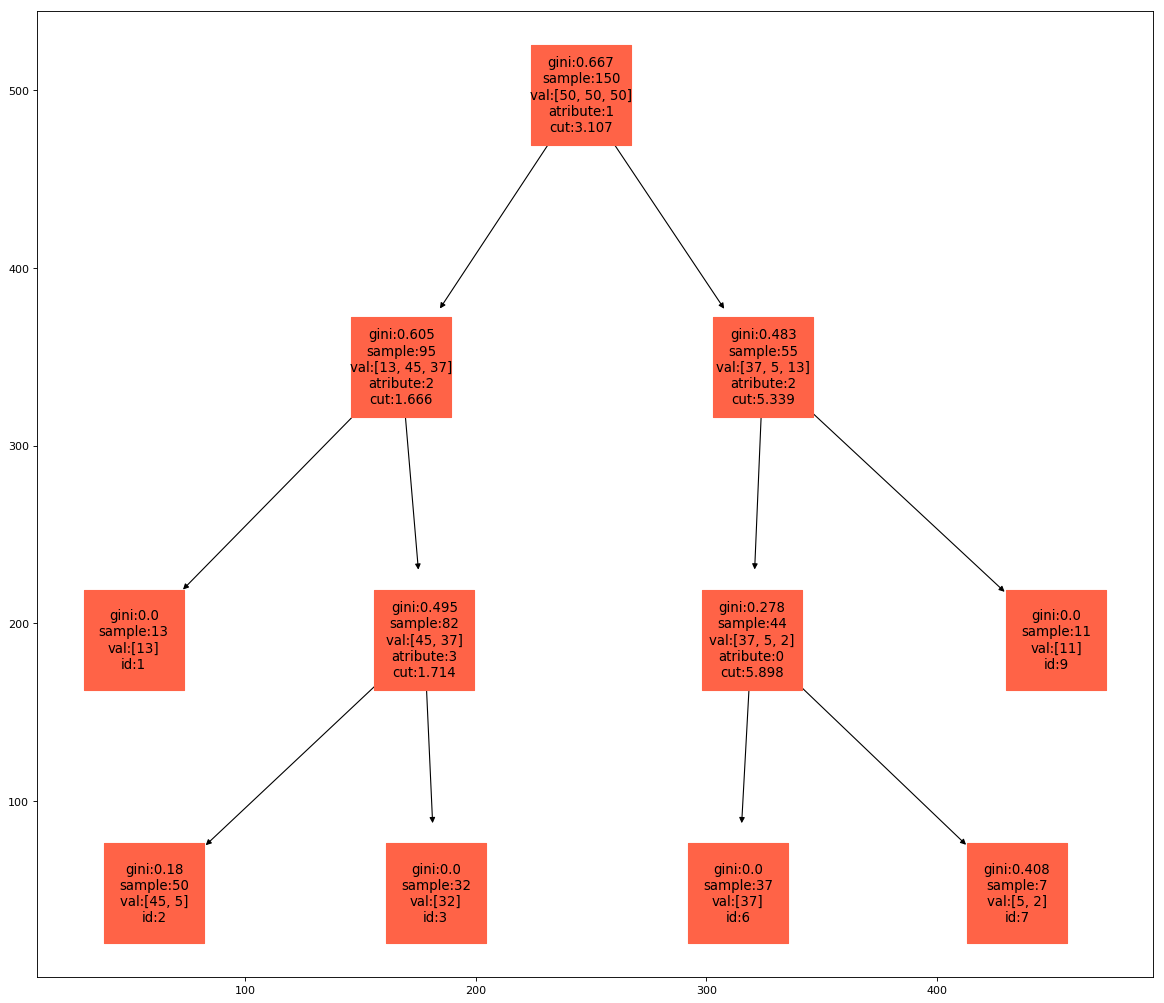

In [6]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

def gen_extra_tree(X,Y,K,n_min,tree=[],depth=0,G=nx.DiGraph()):
    #Si le sous ensemble a atteint une taille minimale ou si les classes sont homogenes
    #Alors il s'agit d'une feuille et elle est simplement renvoyée
    #la profondeur est limitée pour ne pas surcharcher l'affichage
    if len(Y) < n_min or len(np.unique(X))==1 or len(np.unique(Y))==1 or depth>=3:
        #calcul de l'indince de Gini
        unique,counts=np.unique(Y,return_counts=True)
        score=gini_score(Y)
        #La feuille est ajoutée au noeud
        leaf={'gini':round(score,3),
              'sample':len(Y),
              'val':list(counts),
              'id':len(tree)+1}
        return [leaf]
    else:
        depth+=1
        #Selection aleatoire de K atributs parmis les attribus possibles
        atributes_list = random.sample(range(np.shape(X)[1]),K)
        cut_points,scores=[],[]
        for a in atributes_list:
            #Selection d'un seuil ac aleatoire sur l'attribut a
            ac,score=pick_a_random_split(X,Y,a)
            cut_points.append(ac)
            scores.append(score)
        #le seuil selectioné est celui avec le meilleur score
        selected_split = cut_points[np.argmin(scores)]
        #l'attribut selectioné est celui sur lequel le seuil donne le meilleur score
        selected_attribute = atributes_list[np.argmin(scores)]
        
        #Ajout du noeud actuel à l'arbre
        unique,counts=np.unique(Y,return_counts=True)
        node={'gini':round(gini_score(Y),3),
              'sample':len(Y),
              'val':list(counts),
              'atribute':selected_attribute,
              'cut':round(selected_split[0],3)}
        
        G.add_node("\n".join([e[0]+":"+str(e[1]) for e in node.items()]))
        
        #Generation recursive de la suite de l'arbre sur les sous parties a droite et a gauche du seuil
        subPopulation_left=[X[X[:,selected_attribute]<=selected_split],Y[X[:,selected_attribute]<=selected_split]]
        subPopulation_right=[X[X[:,selected_attribute]>selected_split],Y[X[:,selected_attribute]>selected_split]]
        
        #Ajout, a l'abre, des sous-noeuds ou feuilles a droite et a gauche
        tree.append(gen_extra_tree(subPopulation_left[0],subPopulation_left[1],K,n_min,tree,depth,G)[0])
        G.add_edge("\n".join([e[0]+":"+str(e[1]) for e in node.items()]),
                   "\n".join([e[0]+":"+str(e[1]) for e in tree[-1].items()]))
        tree.append(gen_extra_tree(subPopulation_right[0],subPopulation_right[1],K,n_min,tree,depth,G)[0])
        G.add_edge("\n".join([e[0]+":"+str(e[1]) for e in node.items()]),
                   "\n".join([e[0]+":"+str(e[1]) for e in tree[-1].items()]))
        return node,tree,G

_,_,G=gen_extra_tree(iris.data,iris.target,2,1)
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w')
nx.draw_networkx(G, node_shape="s",node_color='tomato',node_size=8000,pos=graphviz_layout(G,prog='dot'))
plt.show()

Un ensemble d'extra tree est ensuite une simple liste de $M$ arbres

In [7]:
def gen_extra_tree_ensemble(X,Y,M=100):
    T=[]
    for i in range(M):
        T.append(gen_extra_tree(X,Y))
    return T     

Tachons de voir ce que cela donne avec Sci-kit learn 

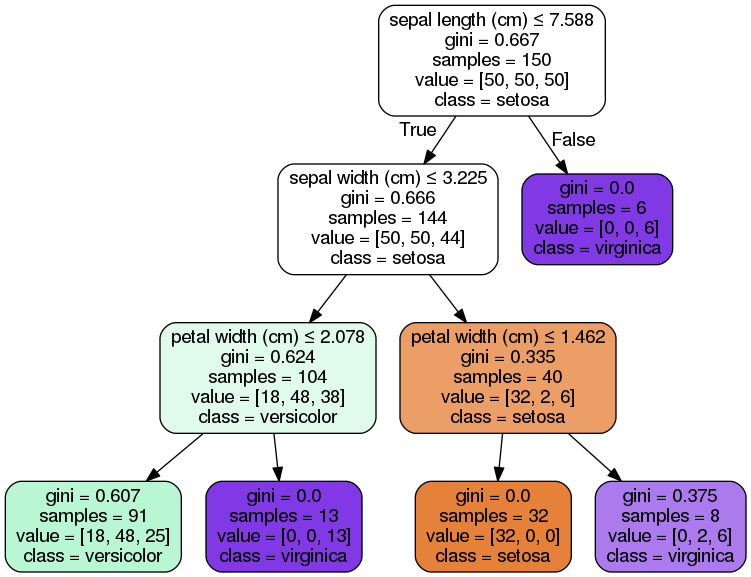

In [8]:
iris = datasets.load_iris()
iris_dt = tree.ExtraTreeClassifier(max_depth=3)
iris_dt.fit(iris.data, iris.target)
tree.export_graphviz(iris_dt,
                     out_file='tree.dot',
                     feature_names = iris.feature_names,
                     class_names=iris.target_names,
                     filled=True,
                     rounded=True,
                     special_characters=True)
disp_iris_tree('iris_dt',iris_dt)

Vous pouvez relancer plusieurs fois la cellule pour constater combien cet Extremly Randomized Tree est extrêmement aléatoire tant dans ses attributs sélectionnés que sur les valeurs des seuils choisis. Tout l'intérêt de ces arbres extrêmement aléatoires est qu'ils formeront une foret d'arbres qui collectivement sera très performante.

<div class="alert alert-success" style="margin-top: 1em">
**A retenir sur la methode Extremely Randomized Trees:**:
<ul>
<li>Méthode d'ensemble sur plusieurs arbres</li>
<li>Sélection aléatoire des attributs</li>
<li>Les coupes dans les arbres sont aléatoires</li>
<li>**Pas de bootstraping** nécessaire</li>
</ul>
</div>
<div class="alert-warning"><a href="#answers1" data-toggle="collapse">**Pour aller plus loin:**:</a><br>
<div id="answers1" class="collapse">
On peut essayer d'autres critères que l'indice de Gini. Celui-ci est présent par défaut dans sci-kit learn mais il est aussi possible d'utiliser. Pour ceux-là je vous renvoie au cours n°8 sur les arbres de décision 
</div>
</div>

# <a id="sec3"></a> 3. Mise en pratique, classification musicale

Désormais que nous nous sommes familiarisées avec les particularités de la méthode Etreme Randomized Trees, nous allons voir comment la mettre en œuvre avec sklearn. Ce notebook sera aussi l'occasion de traiter un petit cas d'usage quelque peu diffèrent de ceux que nous avons traités jusqu'alors. L'objectif est ici de classer un extrait musical (le vôtre par exemple) parmi plusieurs catégories (blues, classical, country, disco, hiphop, jazz, metal, rock)

## 3.1 Un petit mot sur le probleme

Pour ce faire nous disposons d'un data set de référence GTZAN Genre Collection. Il contient plusieurs genres avec 100 extraits en format .wav pour chaque genre : 

http://marsyasweb.appspot.com/download/data_sets/

http://opihi.cs.uvic.ca/sound/genres.tar.gz

Afin de vous épargne les plus d'un 1 Go de données à télécharger, j'adjoins à ce notebook les données déjà extraites et prétraitées prêtes pour la phase d'apprentissage. Rappelons tout de même que dans le processus de développement du MachineLearning la préparation et le pré-traitement des données représente une part importante sinon la majorité du temps de développement. Pour les plus intéressées d'entre vous, je laisse le code dans un fichier "utils.py" contenant les fonctions nécessaires à ce processus.


Pour le classifieur on se basera en premier lieu sur la transformée de Fourier de chaque morceau. Chaque morceau de musique est donc caractérisé par ses 2000 premiers coefficients de Fourier. A chacun de ces morceaux on associe un label qui est un genre musical. L'objectif est de prédire convenablement le genre auquel appartient le morceau de musique. Quelques extraits ont été inséré dans ce notebook avec leur spectre et leur spectrogramme.

In [9]:
import IPython.display as ipd
# ! Casque recomandé
ipd.Audio(filename='./ressource/classical.00058.wav')

In [10]:
ipd.Audio(filename='./ressource/metal.00090.wav')

In [11]:
ipd.Audio(filename='./ressource/blues.00090.wav')

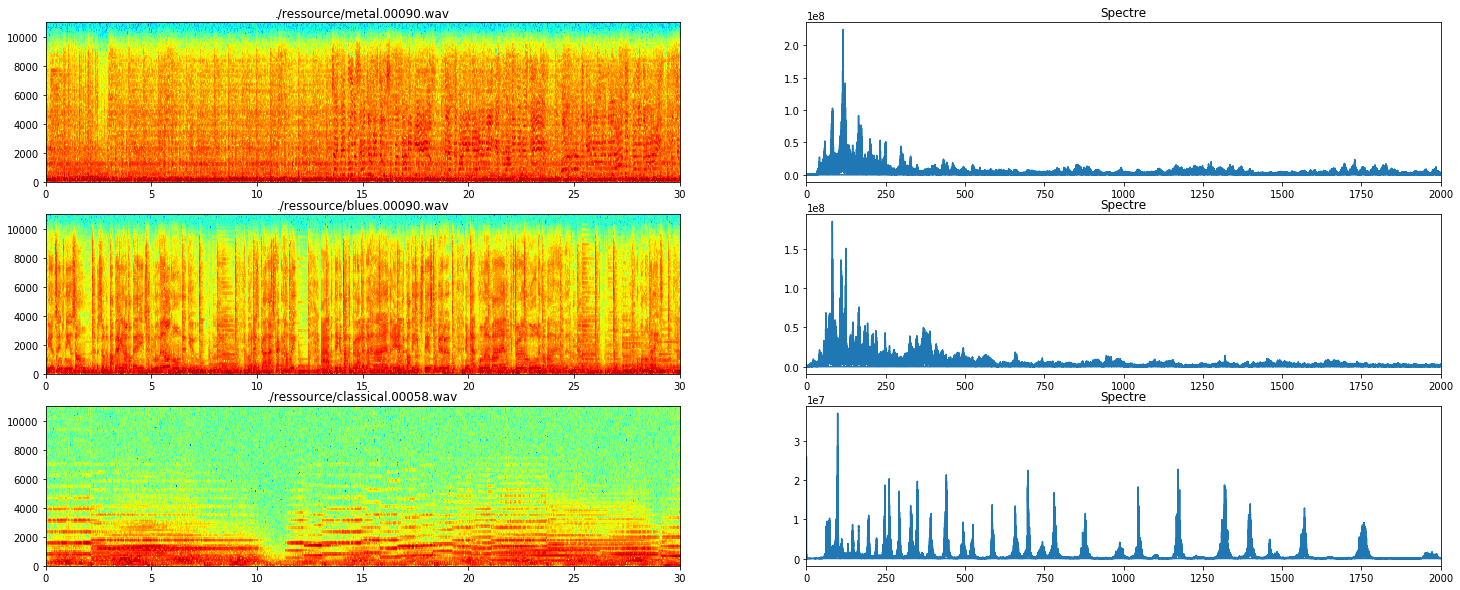

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import EngFormatter
import scipy.io.wavfile
import numpy as np
import glob
import os

filenames =glob.glob(os.path.join('./', 'ressource', "*.wav"))
fig,axes = plt.subplots(3, 2, figsize=(25, 10))
for ax,filename in zip(axes, filenames):
    rate, X = scipy.io.wavfile.read(filename)
    ax[0].specgram(X, Fs=rate, xextent=(0, 30), cmap='jet')
    ax[0].set_title(filename)
    spectrum = np.fft.fft(X)
    freq = np.fft.fftfreq(len(X), 1.0 / rate)
    ax[1].plot(freq, abs(spectrum))
    ax[1].set_xlim(0,2000)
    ax[1].set_title('Spectre')
plt.show()

<div class="alert alert-warning" style="margin-top: 1em">
Le script ci-dessous va télécharger les fichiers de données Il devrait créer le dossier data et télécharger les données depuis Github sans problème. Si ça ne fonctionne pas il est toujours possible de créer manuellement le dossier data et d'y déposer les deux fichiers directement téléchargés depuis Github 
</div>


In [13]:
from six.moves import urllib
import errno

url_X='https://github.com/axelmanguy/ExtremelyRandomizedTrees/raw/master/data/X.npy'
url_Y='https://github.com/axelmanguy/ExtremelyRandomizedTrees/raw/master/data/Y.npy'

file_path_X = os.path.join('./data', 'X.npy')
file_path_Y = os.path.join('./data', 'Y.npy')

if not os.path.exists(file_path_X) and not os.path.exists(file_path_X):
    try:
        os.makedirs('./data')
    except OSError as e:
        if e.errno == errno.EEXIST:
            pass
        else:
            raise
    print('Downloading ' + url_X)
    data = urllib.request.urlopen(url_X)
    with open(file_path_X, 'wb') as f:
        f.write(data.read())
    print('Done')
    print('Downloading ' + url_Y)
    data = urllib.request.urlopen(url_Y)
    with open(file_path_Y, 'wb') as f:
        f.write(data.read())
    print('Done')
else:
    print('Already downloaded')

Already downloaded


Tachons maintenant de faire apprendre à notre modèle à classer la musique. Comme nous ne travaillons que sur les coefficients de fourrier des extraits musicaux, l'aspect énergétique des signaux ne sera pas pris en compte dans la classification. Et l'on s'attend naturellement à ce que les catégories les mieux classées soient celle avec le contenu fréquentiel le plus discriminant. (Dans les extraits ci-dessus, l'extrait de musique classique présente un spectre très différent des autres catégories)


Pour évaluer la performance de notre classifieur on se base sur la moyenne des scores obtenu après validation croisée (sur 10 itérations). La matrice de confusion obtenue nous montre un classifieur un peu décevant quoique déjà intéressant. Un travail sur les features de notre dataset nous permettrait d'améliorer notre classifieur (cf[3]) Comme ce n'est pas l'objet ici nous nous contenterons de ces résultats et de les comparer avec la méthode ExtremelyRandomizedTree

(800, 2000)
(800,)
**********
Average generalization score: 0.4925
Standard deviation: 0.029918871785027074


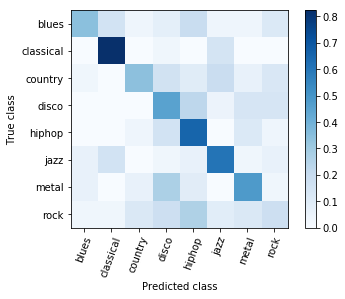

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#Chargement des données (les coeffiscients de fourier et les labels)
X=np.load('./data/X.npy')
Y=np.load('./data/Y.npy')
print(np.shape(X))
print(np.shape(Y))

#CrossValidation
score = []
n_iter=10
for i in range(n_iter):
    #split en test train
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    #classifieur
    classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', bootstrap=True)
    classifier.fit(X_train,y_train);
    #scoring
    score += [classifier.score(X_test,y_test)]
    print('*', end='')
    
print("\nAverage generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))


#matrice de confusion du dernier classifieur
y_pred = classifier.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
plt.imshow(cnf_matrix,cmap=plt.cm.Blues)
classes=np.unique(y_pred)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(tick_marks, classes, rotation=70)
plt.yticks(tick_marks, classes)
plt.show()

A vous maintenant, je vous laisse apporter les légères modifications au code ci-dessus pour utiliser un Classifieur à base d'Extremely randomized trees. A cette fin je vous indique la classe ExtraTreesClassifier qui fonctionne comme tous les autres modèles de scikit learn.

(800, 2000)
(800,)
**********
Average generalization score: 0.515
Standard deviation: 0.032231799343022866


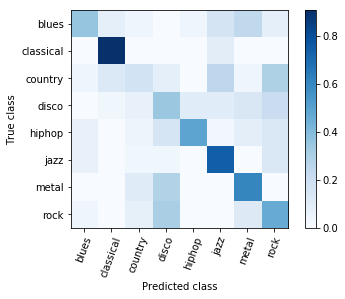

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#Chargement des données (les coeffiscients de fourier et les labels)
X=np.load('./data/X.npy')
Y=np.load('./data/Y.npy')
print(np.shape(X))
print(np.shape(Y))

#CrossValidation
score = []
n_iter=10
for i in range(n_iter):
    #split en test train
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    #classifieur
    classifier = ExtraTreesClassifier(n_estimators=200, criterion='entropy')
    classifier.fit(X_train,y_train);
    #scoring
    score += [classifier.score(X_test,y_test)]
    print('*', end='')
    
print("\nAverage generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))


#matrice de confusion du dernier classifieur
y_pred = classifier.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
plt.imshow(cnf_matrix,cmap=plt.cm.Blues)
classes=np.unique(y_pred)
tick_marks = np.arange(len(classes))
plt.colorbar()
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(tick_marks, classes, rotation=70)
plt.yticks(tick_marks, classes)
plt.show()

Vous devriez constater dés à présent un avantage majeur de la méthode ExtraTree : Sa rapidité. Comme l'algorithme ne dldldldld il présente une complexité bien moindre et converge beaucoup plus rapidement que la méthode random forest. Pour notre exemple ses résultats ne sont pas nécessairement meilleurs mais sont tout de même très proche. Et c'est d'ailleurs une conclusion importante sur cette méthode. Elle donne des résultats équivalent ou très légèrement meilleurs. Son intérêt réside donc surtout dans sa rapidité.

<div class="alert alert-success" style="margin-top: 1em">
**A retenir sur le cas d'application:**:
<ul>
<li>ExtraTrees et RandomForest ont des résultats comparables</li>
<li>ExtraTrees est beaucoup plus rapide que RandomForest</li>
<li>La méthode fournit un classifieur sur étagère rapide et aux performances acceptables</li>
</ul>
</div>

<div class="alert-warning"><a href="#answers3" data-toggle="collapse">**Pour aller plus loin:**:</a><br>
<div id="answers3" class="collapse">
On peut améliorer le classifieur en utilisant d'autres données que la transformée de Fourier du signal sonore. A cette fin l'article [3] de Tzanetakis montre des résultats intéressants en procédant par utilisation des mel-frequency  cepstral  coefficients. Si vous voulez essayer de voir ce que cela donne vous pouvez télécharger les données sur mon Github avec les url : 
<ul>
<li>url_X='https://github.com/axelmanguy/ExtremelyRandomizedTrees/raw/master/data/X_MFCC.npy'</li>
<li>url_Y='https://github.com/axelmanguy/ExtremelyRandomizedTrees/raw/master/data/Y_MFCC.npy'</li>
</ul>
    
En lieu et place de ceux présent actuellement 
</div>
</div>

# <a id="sec4"></a> 4.Avantages, Résultats et hyper parametres

On dénombre 3 paramètres important pour entrainer notre forêt d'arbres à base d'ExtraTrees.
2 paramètres ont trait aux arbres eux même: $K$, le nombre d'attributs selectionés et $n_{min}$,la taille minimum d'un échantillon pour diviser un noeaud

Le troisième paramètre est $M$, le nombre d'arbres dans le classifieur. De manière assez classique la forêt d'arbres fonctionne par vote majoritaire
 
En terme d'influence, $K$ pilote la séléction des attributs. En pratique reduire $K$, amène à plus d'aleatoire et à moins de dépendence aux structures des données d'apprentissage.
$n_{min}$ pilote la taille des arbres et renforce la variance dans le  compromis classique biais/variance

En terme de résultats et comme nous l'avons vus, le classifieur ExtraTree est aussi performant ou plus performant que la pluspart des méthodes d'ensemble sur arbre de decision mais présente une complexité bien moindre. Il est ainsi beaucoup plus rapide que la plus part des autres methodes.

score en fonction de K sur k= [  1  21  41  61  81 101 121 141]
********

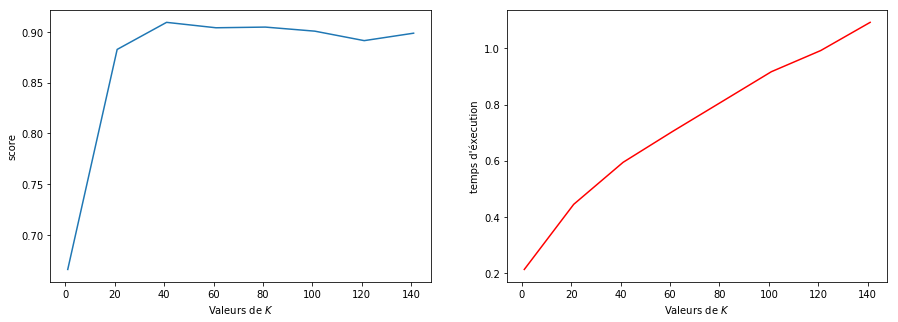

In [41]:
import time
X, y = datasets.make_classification(n_samples=1000,
                                    n_features=200)
K_list=np.arange(1,160,20)
print('score en fonction de K sur k=',str(K_list))
n_iter=5
scores,times=[],[]
for k in K_list:
    mean_score,mean_time=[],[]
    print('*',end='')
    for iter in range(n_iter):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        classifier = ExtraTreesClassifier(n_estimators=200, criterion='entropy',max_features=k)
        t1=time.time()
        classifier.fit(X_train, y_train)
        t2=time.time()
        mean_score.append(classifier.score(X_test,y_test))
        mean_time.append(abs(t2-t1))
    scores.append(np.mean(mean_score))
    times.append(np.mean(mean_time))
    
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(K_list,scores)
axes[0].set_xlabel('Valeurs de $K$')
axes[0].set_ylabel('score')
axes[1].plot(K_list,times,'r')
axes[1].set_xlabel('Valeurs de $K$')
axes[1].set_ylabel("temps d'éxecution")
plt.show()

score en fonction de $n_{min}$ [  2  52 102 152 202 252 302 352 402 452 502 552 602 652 702 752 802 852
 902 952]
********************

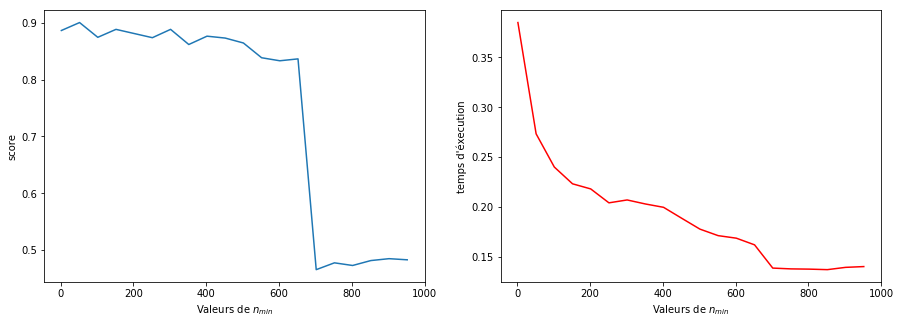

In [44]:
n_list=np.arange(2,1000,50)
print('score en fonction de n_min dans',str(n_list))
n_iter=5
scores,times=[],[]
for n in n_list:
    mean_score,mean_time=[],[]
    print('*',end='')
    for iter in range(n_iter):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        classifier = ExtraTreesClassifier(n_estimators=200, criterion='entropy',min_samples_split=n)
        t1=time.time()
        classifier.fit(X_train, y_train)
        t2=time.time()
        mean_score.append(classifier.score(X_test,y_test))
        mean_time.append(abs(t2-t1))
    scores.append(np.mean(mean_score))
    times.append(np.mean(mean_time))
    
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(n_list,scores)
axes[0].set_xlabel('Valeurs de $n_{min}$')
axes[0].set_ylabel('score')
axes[1].plot(n_list,times,'r')
axes[1].set_xlabel('Valeurs de $n_{min}$')
axes[1].set_ylabel("temps d'éxecution")
plt.show()

score en fonction de M dans [100 150 200 250 300 350 400 450]
********

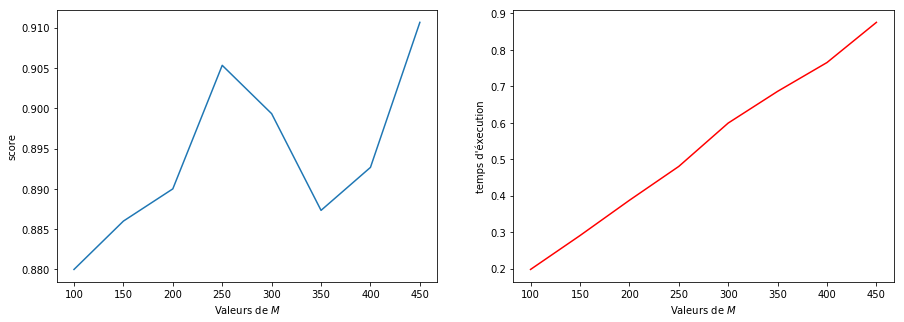

In [47]:
m_list=np.arange(100,550,50)
print('score en fonction de M dans',str(m_list))
n_iter=5
scores,times=[],[]
for m in m_list:
    mean_score,mean_time=[],[]
    print('*',end='')
    for iter in range(n_iter):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        classifier = ExtraTreesClassifier(n_estimators=m, criterion='entropy')
        t1=time.time()
        classifier.fit(X_train, y_train)
        t2=time.time()
        mean_score.append(classifier.score(X_test,y_test))
        mean_time.append(abs(t2-t1))
    scores.append(np.mean(mean_score))
    times.append(np.mean(mean_time))
    
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(m_list,scores)
axes[0].set_xlabel('Valeurs de $M$')
axes[0].set_ylabel('score')
axes[1].plot(m_list,times,'r')
axes[1].set_xlabel('Valeurs de $M$')
axes[1].set_ylabel("temps d'éxecution")
plt.show()

<div class="alert alert-success" style="margin-top: 1em">
**A retenir sur le compromis temps/performance:**:
<ul>
<li>$n_{min}$ peut etre reduit si le temps d'execution doit etre diminué mais les performances diminueront à partir d'un certain point.</li>
<li>Lorsque K augmente les perfomances augmentent mais le temps d'execution egallement</li>
<li>Les performances evoluent peu avec l'augmentation du nombre d'arbre mais le temps d'execution augmente lineairement</li>
</ul>


Selectioner les bon $K$,$n_{min}$ et $M$ dépendera, bien entendu du problème auquel vous serez confrontés. Vous pouvez neanmoins retenir qu'ExtraTree est une methode aussi efficace que RandomForest mais beaucoup plus rapide et que cela peut vous permettre des modèles de plus grande taille pour le même temps d'execution.
</div>

# References
<ul>
<li> [1] Article du Sujet : [Extremely randomized trees, Geurts, P., Ernst, D. & Wehenkel, L. Mach Learn (2006)](https://link.springer.com/content/pdf/10.1007%2Fs10994-006-6226-1.pdf)</li>
<li> [2] Impurté de Gini : https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity</li>
<li> [3] Music classification :http://ismir2001.ismir.net/pdf/tzanetakis.pdf</li>
</ul>